# Algoritmos Metaheurísticos: Examen 2
Profesor: Dr. Marco Aceves <br>
Alumno: Ing. Enrique Mena Camilo

In [1]:
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dateutil.parser import parse
from sklearn.linear_model import LinearRegression

sys.path.append('..')

from utils.population import init_binary_population
from utils.aptitude import evaluate_population
from utils.selection import polygamous_random_selection
from utils.crossover import two_point_crossover
from utils.visualization import plot_aptitude
from utils.mutation import inverse_mutation
from utils.casting import bin_array_to_int

sns.set(style="darkgrid")


## EDA

In [2]:
data = pd.read_excel(
    "data/DMN Report 29.xlsx",
    sheet_name=[0, 1, 2, 3, 4, 5],
    header=None, skiprows=5, usecols=[0, 1, 2],
    names=["WEEK", "LACTOSE", "WHEY"]
)
data.keys()


dict_keys([0, 1, 2, 3, 4, 5])

### Unión de datos en un único dataframe

In [3]:
def month_to_q(month: str):
    if month in [1, 2, 3]:
        return 1
    elif month in [4, 5, 6]:
        return 2
    elif month in [7, 8, 9]:
        return 3
    elif month in [10, 11, 12]:
        return 4
    else:
        return None


In [4]:
clen_data = []
year = 2023
for idx in range(len(data)):
    year_data = data[idx].copy()
    # Elimina las filas "AVG"
    year_data = year_data[~year_data["WEEK"].astype(str).str.contains("AVG")]
    # Estandarizamos el formato de la columna "WEEK"
    year_data["WEEK"] = year_data["WEEK"].astype(str).transform(lambda x: (x.replace(" ", "").split("-")[0]))
    # Elimninamos las filas nan
    year_data = year_data.dropna()
    # Agregamos el año
    year_data["YEAR"] = year
    # Agregamos el mes
    year_data["MONTH"] = year_data["WEEK"].transform(lambda x: parse(x).month)
    # Agregamos el trimestre
    year_data["QUARTER"] = year_data["MONTH"].transform(month_to_q)# Agregamos al arreglo
    # Agrupamos el año-quarter
    year_data["YEAR_QUARTER"] = year_data['YEAR'].astype(str) + "-Q" + year_data['QUARTER'].astype(str)
    # Agregamos al arreglo
    clen_data.append(year_data.copy())
    # Disminuimos el año
    year -= 1
    del year_data

# Concatenamos los datos
clean_data = pd.concat(clen_data).reset_index(drop=True)

clean_data.sample(10)


,WEEK,LACTOSE,WHEY,YEAR,MONTH,QUARTER,YEAR_QUARTER
110,5/31/21,0.45000,0.63750,2021,5,2,2021-Q2
157,4/20/20,0.35500,0.35250,2020,4,2,2020-Q2
277,1/29/18,0.21250,0.24250,2018,1,1,2018-Q1
296,6/11/18,0.26625,0.31375,2018,6,2,2018-Q2
264,2/3,0.59500,0.58500,2018,2,1,2018-Q1
42,2/14/22,0.40500,0.80125,2022,2,1,2022-Q1
124,9/6/21,0.44000,0.50000,2021,9,3,2021-Q3
14,4/10/23,0.28500,0.44000,2023,4,2,2023-Q2
276,1/22/18,0.21250,0.24250,2018,1,1,2018-Q1
1,1/9/23,0.47250,0.40250,2023,1,1,2023-Q1


### Estadistica descriptiva global

In [5]:
clean_data[['LACTOSE', 'WHEY']].describe().T


,count,mean,std,min,25%,50%,75%,max
LACTOSE,326.0,0.387347,0.103796,0.1925,0.305,0.4050,0.455000,0.635
WHEY,326.0,0.440479,0.132571,0.2350,0.350,0.4225,0.556875,0.805


### Graficos de distribución por año

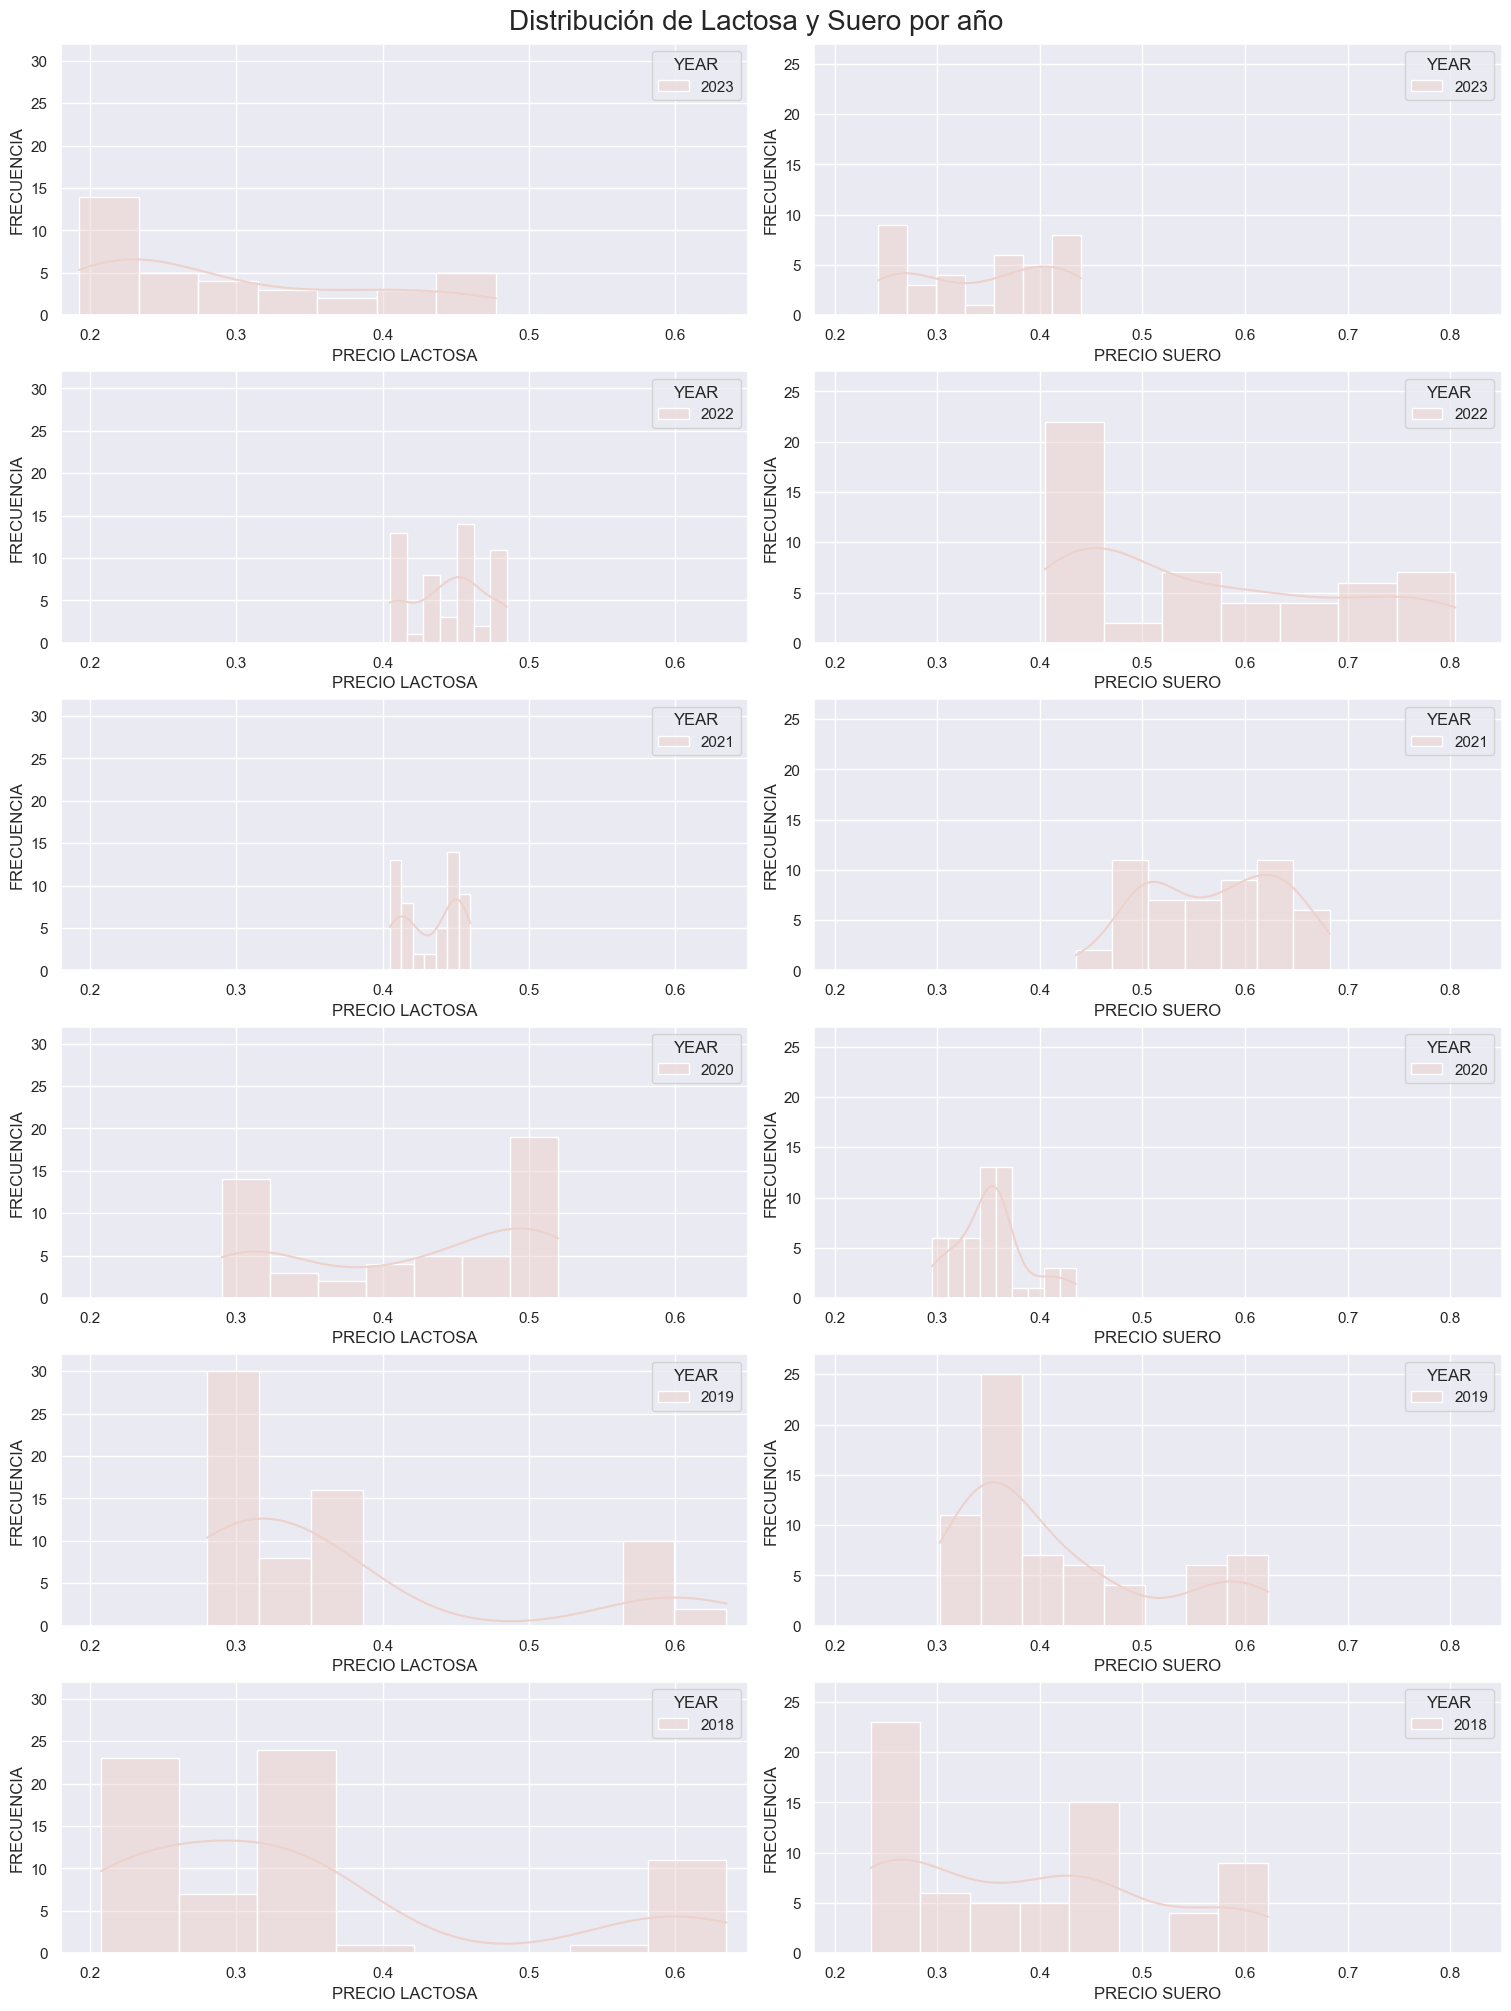

In [6]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20), layout="constrained")
fig.suptitle("Distribución de Lactosa y Suero por año", fontsize=20)

for idx, ax in enumerate(axes):
    year_data = clean_data[clean_data["YEAR"] == 2023-idx]
   
    sns.histplot(data=year_data, x="LACTOSE", hue="YEAR", kde=True, ax=ax[0])
    sns.histplot(data=year_data, x="WHEY", hue="YEAR", kde=True, ax=ax[1])
    
    ax[0].set_ylim(0, 32), ax[0].set_xlim(0.18, 0.65)
    ax[0].set_ylabel("FRECUENCIA"), ax[0].set_xlabel("PRECIO LACTOSA")
    
    ax[1].set_ylim(0, 27), ax[1].set_xlim(0.18, 0.85)
    ax[1].set_ylabel("FRECUENCIA"), ax[1].set_xlabel("PRECIO SUERO")
    

plt.savefig(f"figures/distribuciones_precio.png", bbox_inches='tight', dpi=300)


### Variación del precio sobre el tiempo

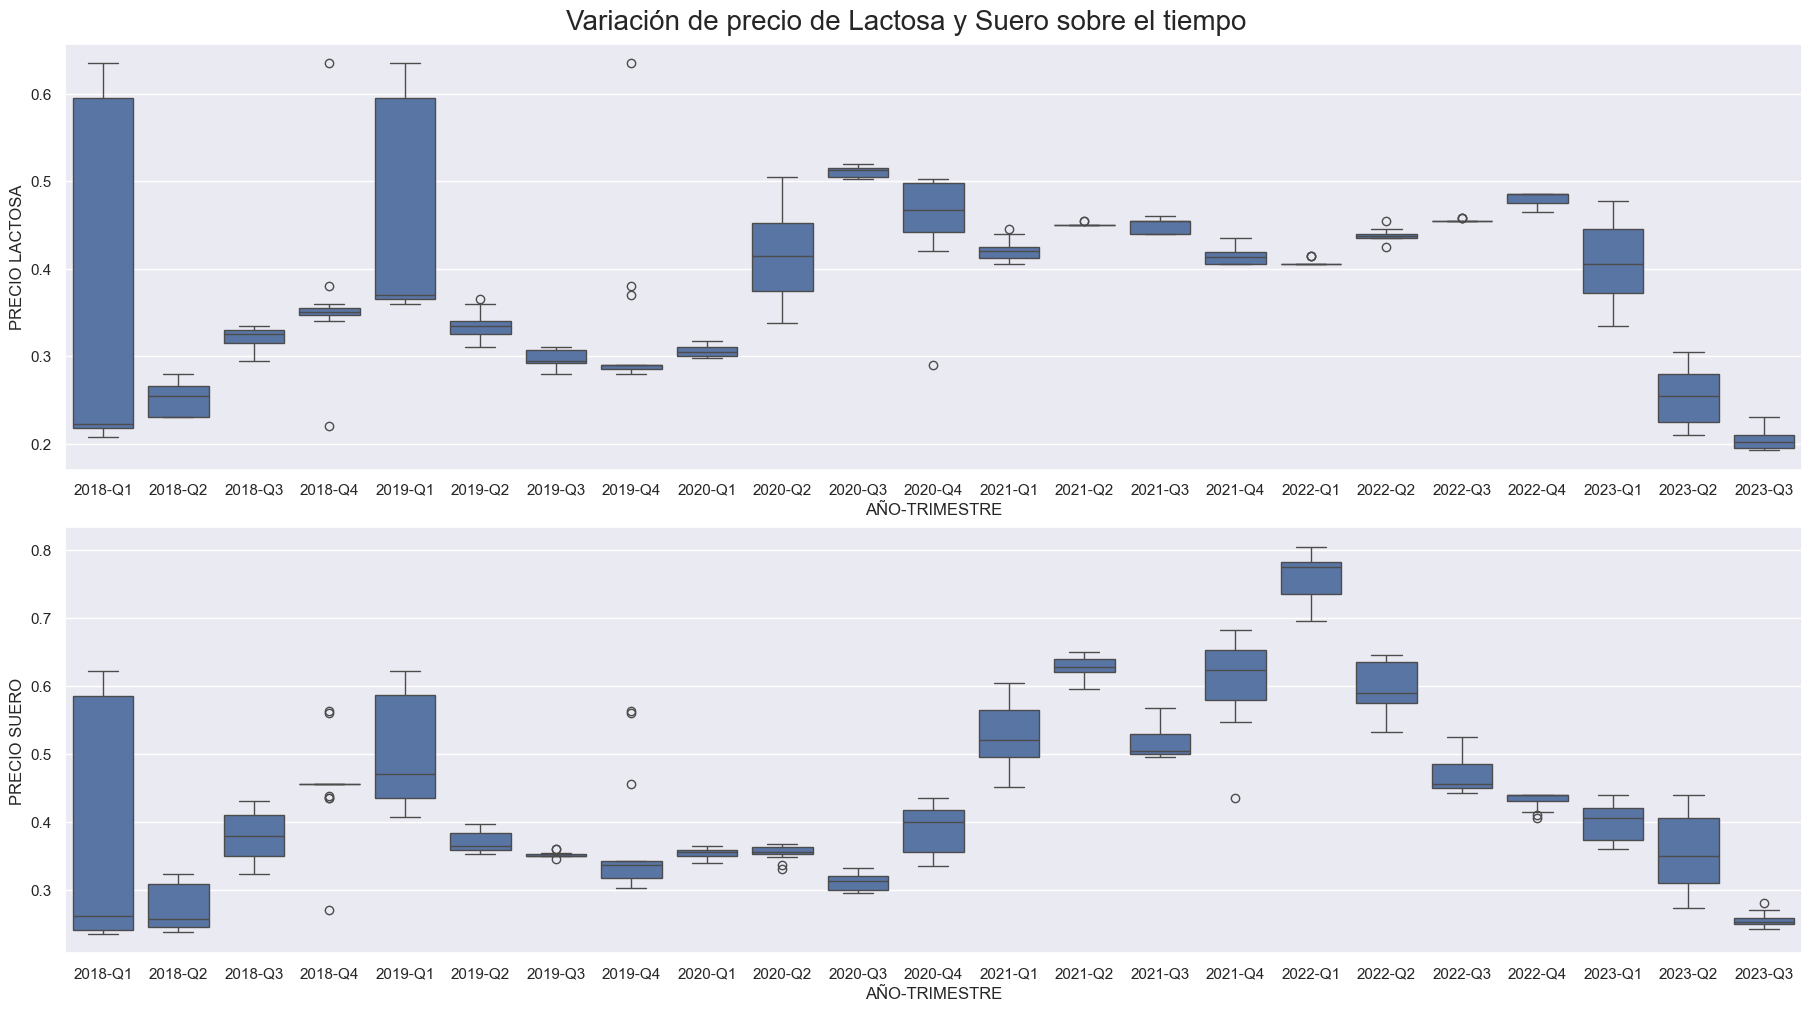

In [7]:
order = sorted(clean_data["YEAR_QUARTER"].unique())

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 10), layout="constrained")
fig.suptitle("Variación de precio de Lactosa y Suero sobre el tiempo", fontsize=20)

sns.boxplot(x="YEAR_QUARTER", y="LACTOSE", data=clean_data, order=order, ax=axes[0])
sns.boxplot(x="YEAR_QUARTER", y="WHEY", data=clean_data, order=order, ax=axes[1])

axes[0].set_ylabel("PRECIO LACTOSA"), axes[0].set_xlabel("AÑO-TRIMESTRE")
axes[1].set_ylabel("PRECIO SUERO"), axes[1].set_xlabel("AÑO-TRIMESTRE")

plt.savefig(f"figures/precio_tiempo.png", bbox_inches='tight', dpi=300)


## Función de aptitud

In [8]:
clean_data[["YEAR_QUARTER", "LACTOSE", "WHEY"]].sample(10)


,YEAR_QUARTER,LACTOSE,WHEY
302,2018-Q3,0.3150,0.35000
313,2018-Q4,0.3475,0.43500
37,2022-Q1,0.4050,0.71500
120,2021-Q3,0.4550,0.50375
308,2018-Q3,0.3300,0.41000
91,2021-Q1,0.4050,0.49000
44,2022-Q1,0.4050,0.78250
34,2023-Q3,0.2250,0.27000
45,2022-Q1,0.4050,0.78250
229,2019-Q2,0.3150,0.35500


Se necesita determinar un modelo de precio que maximice las ganancias, el cuál está establecido por
$$R(p) = pD(p)$$
Donde:
- $R(P)$ es la ganancia
- $p$ es el precio del producto
- $D(p)$ la demanda del producto al precio $p$

Además, $D(p)$ se establece como
$$D(p) = a - bp$$
Donde $a$ y $b$ son parámetros de nuestro modelo

### Datos sintéticos de inventario

Para facilitar el análisis, se generan datos sintéticos de inventario, y se asume que durante las ventas fueron totales, es decir, la demanda fue igual a inventario

In [9]:
def fit_stock(stock: int):
    if stock < 2000:
        return 2000
    if stock > 10000:
        return 10000
    return stock


In [10]:
stock_lactose = np.random.normal(loc=5000, scale=2000, size=len(clean_data)//3).astype(int)
clean_data["STOCK_LACTOSE"] = np.random.choice(stock_lactose, size=len(clean_data))
clean_data["STOCK_LACTOSE"] = clean_data["STOCK_LACTOSE"].transform(fit_stock)


In [11]:
stock_whey = np.random.normal(loc=5000, scale=1500, size=len(clean_data)//3).astype(int)
clean_data["STOCK_WHEY"] = np.random.choice(stock_whey, size=len(clean_data))
clean_data["STOCK_WHEY"] = clean_data["STOCK_WHEY"].transform(fit_stock)


In [12]:
clean_data[["LACTOSE", "STOCK_LACTOSE", "WHEY", "STOCK_WHEY"]].sample(10)


,LACTOSE,STOCK_LACTOSE,WHEY,STOCK_WHEY
177,0.5050,2397,0.30250,7052
225,0.3350,7552,0.36500,5266
141,0.2900,7095,0.34000,2189
223,0.3400,6389,0.37375,7680
185,0.4875,4717,0.38500,2000
137,0.4050,6831,0.65375,4096
144,0.3000,5665,0.35375,4663
85,0.4750,2876,0.41500,3930
209,0.3700,6490,0.47000,5527
265,0.5950,3306,0.58750,3285


### Demanda para Lactosa

In [13]:
lactose_reg = LinearRegression(positive=True).fit(clean_data[["LACTOSE"]], clean_data["STOCK_LACTOSE"])
print(f"D_l(p) = {lactose_reg.intercept_:.4f} - {lactose_reg.coef_[0]:.4f}p ")

def demand_lactose(price: float):
    return 4081.2654 - 1310.4058*price


D_l(p) = 5300.7086 - 0.0000p 


$$D_{lactosa}(p)=4081.2654 - 1310.4058p$$

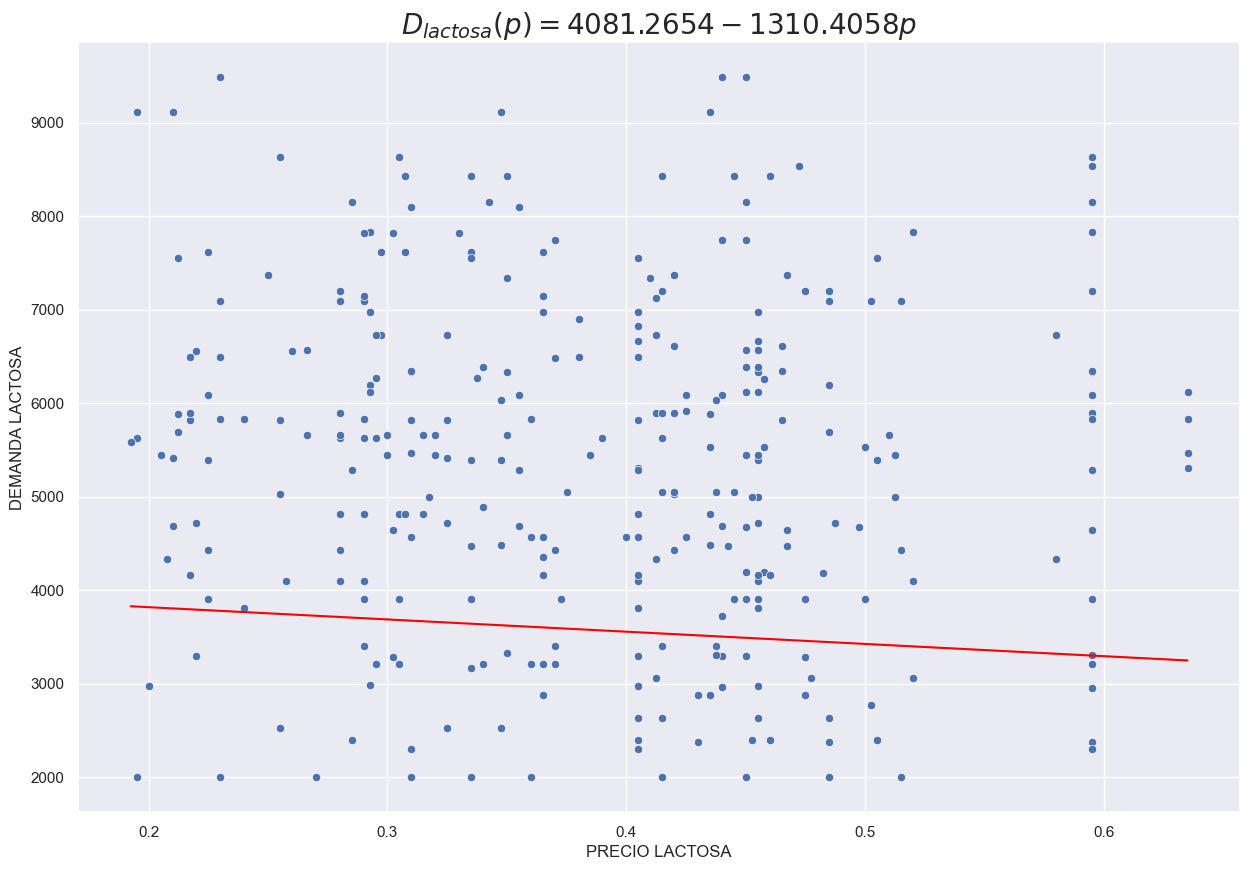

In [14]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("$D_{lactosa}(p)=4081.2654 - 1310.4058p$", fontsize=20)
sns.scatterplot(data=clean_data, x="LACTOSE", y="STOCK_LACTOSE", ax=ax)
sns.lineplot(x=clean_data["LACTOSE"], y=demand_lactose(clean_data["LACTOSE"]), color="red", ax=ax)
ax.set_xlabel("PRECIO LACTOSA"), ax.set_ylabel("DEMANDA LACTOSA")
plt.savefig(f"figures/demanda_lactosa.png", bbox_inches='tight', dpi=300)


### Demanda para Suero

In [15]:
whey_reg = LinearRegression(positive=True).fit(clean_data[["WHEY"]], clean_data["STOCK_WHEY"])
print(f"D_w(p) = {whey_reg.intercept_:.4f} - {whey_reg.coef_[0]:.4f}p ")

def demand_whey(price: float):
    return 4642.2109 - 1050.1823*price


D_w(p) = 4517.4895 - 668.0357p 


$$D_{suero}(p)=4642.2109 - 1050.1823p$$

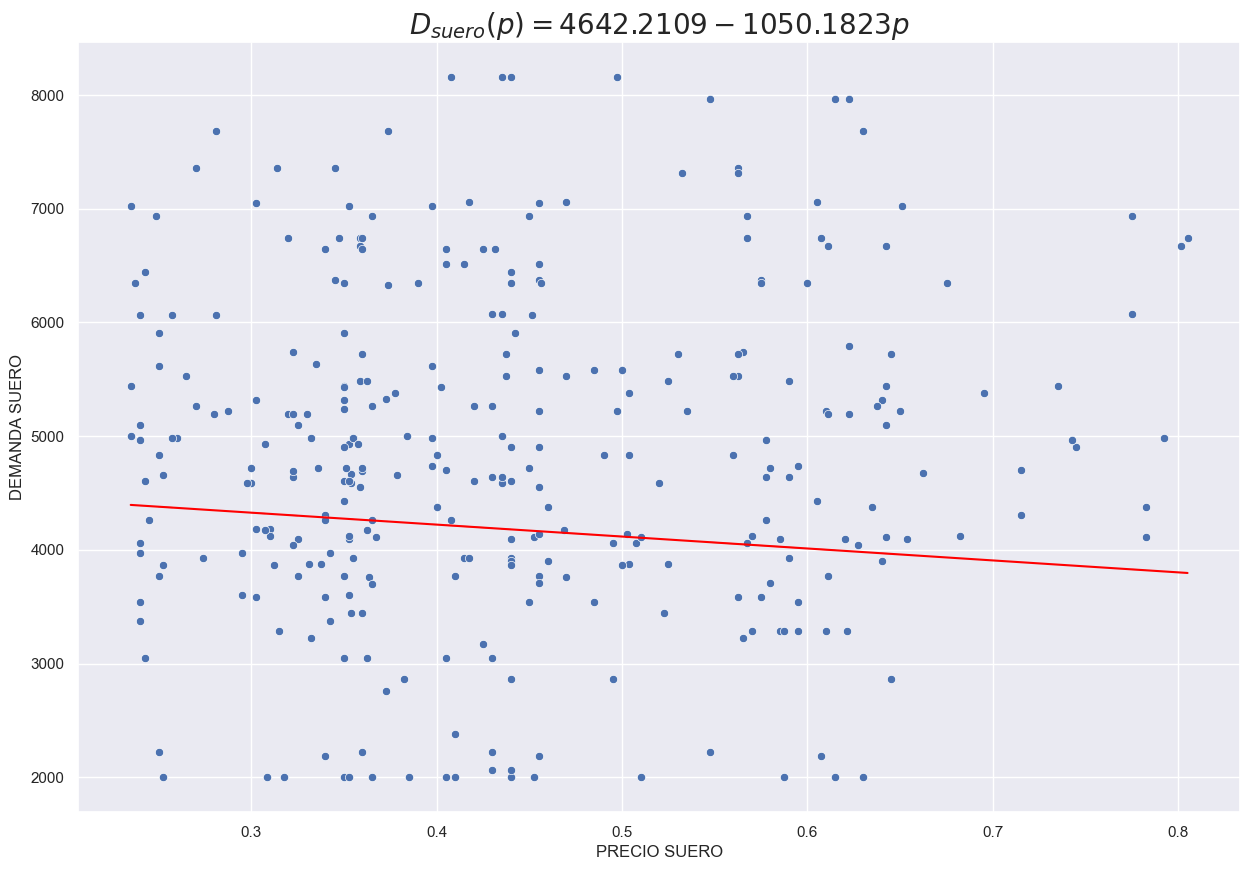

In [16]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("$D_{suero}(p)=4642.2109 - 1050.1823p$", fontsize=20)
sns.scatterplot(data=clean_data, x="WHEY", y="STOCK_WHEY", ax=ax)
sns.lineplot(x=clean_data["WHEY"], y=demand_whey(clean_data["WHEY"]), color="red", ax=ax)
ax.set_xlabel("PRECIO SUERO"), ax.set_ylabel("DEMANDA SUERO")
plt.savefig(f"figures/demanda_suero.png", bbox_inches='tight', dpi=300)


## Funciones de aptitud finales

Para manejar 2 tipos de clientes se realiza un modificación a la ecuación de optimización propuesta.

Si tenemos un cliente premium al que le daremos más "económico" debido a la gran cantidad de producto que compra y no queremos tener perdidas, se buscará optimizar el precio mas el 10%, así determinaremos un punto donde podamos dar "más" economico al cliente premium sin tener perdidas

In [17]:
def revenue_lactose(price: float):
    price = price + price*0.1
    return price * demand_lactose(price)

def revenue_whey(price: float):
    price = price + price*0.1
    return price * demand_whey(price)


$$R_{lactose}=(p + p*0.10)*(4081.2654 - 1310.4058*(p + p*0.10))$$
$$R_{whey}=(p + p*0.10)*(4642.2109 - 1050.1823*(p + p*0.10))$$


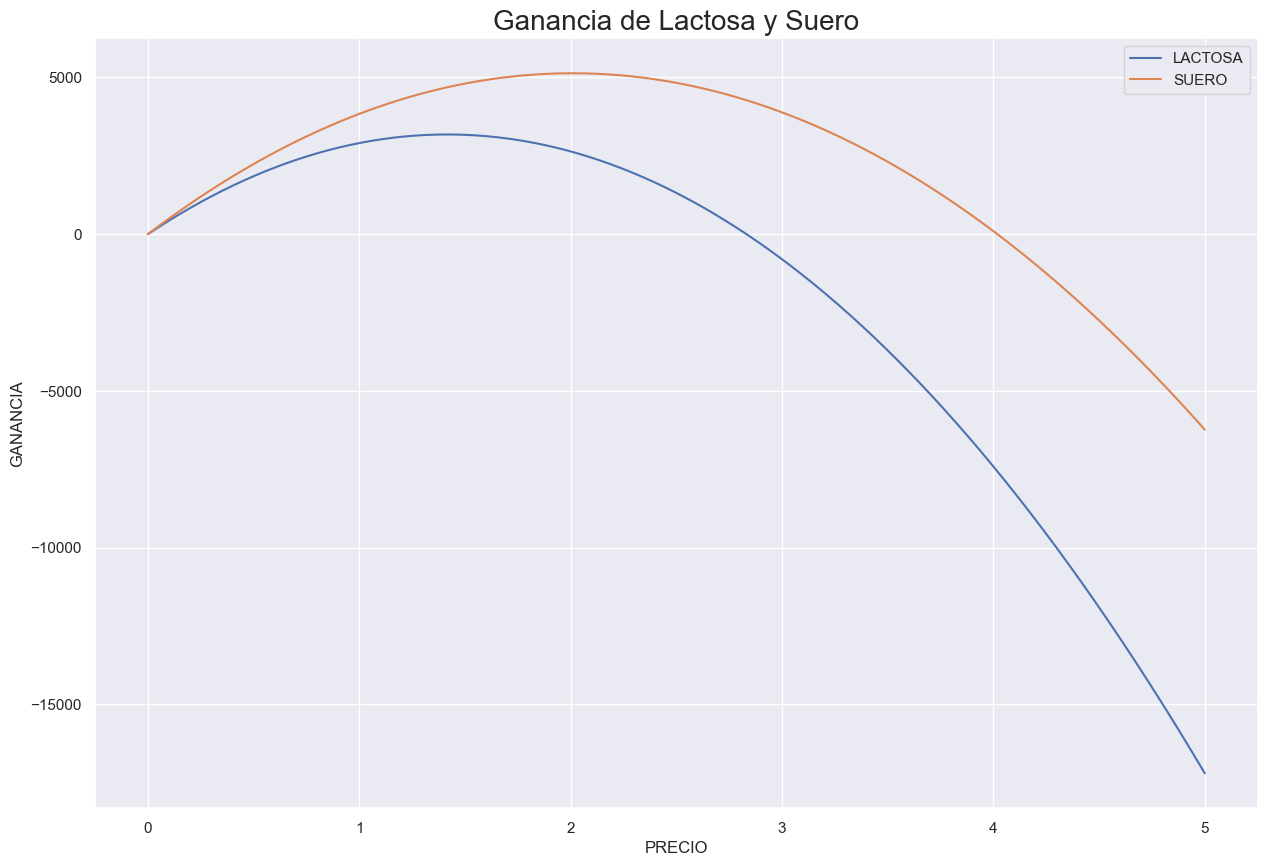

In [18]:
x = np.linspace(0.0, 5, 1000)
y_1 = revenue_lactose(x)
y_2 = revenue_whey(x)

plt.figure(figsize=(15, 10))
plt.title("Ganancia de Lactosa y Suero", fontsize=20)
plt.plot(x, y_1, label="LACTOSA")
plt.plot(x, y_2, label="SUERO")
plt.xlabel("PRECIO"), plt.ylabel("GANANCIA")
plt.legend()
plt.savefig(f"figures/revenue.png", bbox_inches='tight', dpi=300)


## Algoritmo genético

In [19]:
def plot_aptitude(avg_aptitude: np.ndarray, max_aptitude: np.ndarray, max_generations: int, title: str):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(avg_aptitude, "o-",label="Average aptitude")
    plt.plot(max_aptitude, "o-", label="Best aptitude")
    plt.xlabel("Generation")
    plt.ylabel("Aptitude")
    plt.xticks(range(max_generations))
    plt.legend()
    plt.savefig(f"./figures/{'_'.join(title.replace('+', '').lower().split())}.png", bbox_inches='tight')
    plt.show()


def decode_individue(individue: np.ndarray, domain: tuple):
    bits = individue.shape[0]
    min = 0
    max = 2**bits - 1
    decoded_individue = bin_array_to_int(individue)
    decoded_individue = (decoded_individue - min) / (max - min)
    decoded_individue = (domain[1] - domain[0]) * decoded_individue + domain[0]
    return decoded_individue


### Lactosa

Best price: 1.3926909285114824
Best aptitude: 3177.7799555519423
Avg aptitude: 3177.4731121076857


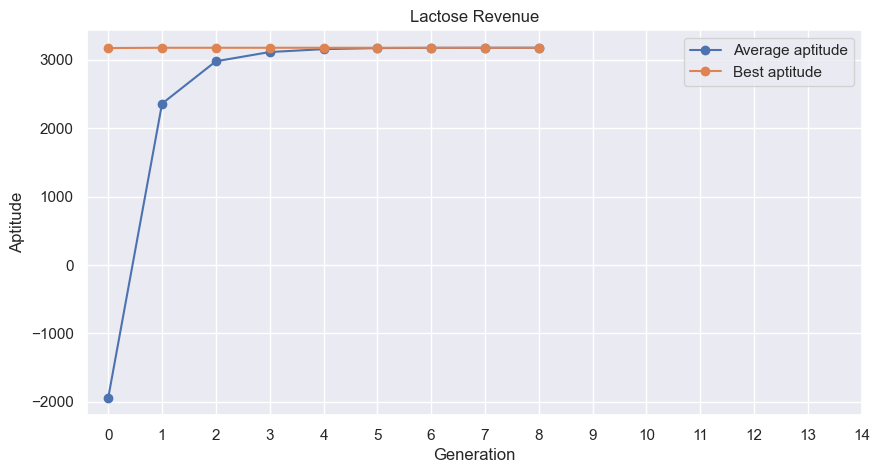

In [20]:
def genetic_competence(population: np.ndarray, childrens: np.ndarray):
    all_population = np.vstack([population, childrens])
    sorted_population, _, _, _ = evaluate_population(all_population, (0, 5), revenue_lactose)
    return sorted_population[:population.shape[0]]


lactose_population = init_binary_population(100, 2**4)
generations = 15
epsilon = 3000
last_avg_aptitude = float("inf")
max_stagnant_generations = 3
stagnant_generations = 0
delta = 30

avg_aptitudes_l = []
max_aptitudes_l = []
evolution_l = []

for _ in range(generations):
    lactose_population, _, avg_aptitude, max_aptitude = evaluate_population(lactose_population, (0, 5), revenue_lactose)
    avg_aptitudes_l.append(avg_aptitude)
    max_aptitudes_l.append(max_aptitude)
    evolution_l.append(lactose_population.copy())
    
    if abs(avg_aptitude - last_avg_aptitude) < delta:
        stagnant_generations += 1
        if stagnant_generations > max_stagnant_generations:
            break
    else:
        stagnant_generations = 0

    last_avg_aptitude = avg_aptitude
    parents = polygamous_random_selection(lactose_population)
    childrens = two_point_crossover(lactose_population, parents)
    childrens = inverse_mutation(childrens, 0.2)
    lactose_population = genetic_competence(lactose_population, childrens)

print(f"Best price: {decode_individue(lactose_population[-1], (0, 5))}")
print(f"Best aptitude: {max_aptitudes_l[-1]}")
print(f"Avg aptitude: {avg_aptitudes_l[-1]}")

title = "Lactose Revenue"
plot_aptitude(avg_aptitudes_l, max_aptitudes_l, generations, title)


$$P_{premium} = 1.3926$$
$$P_{tradicional} = 1.53187$$

### Suero

Best price: 2.025940337224384
Best aptitude: 5130.09066357612
Avg aptitude: 5129.975158957858


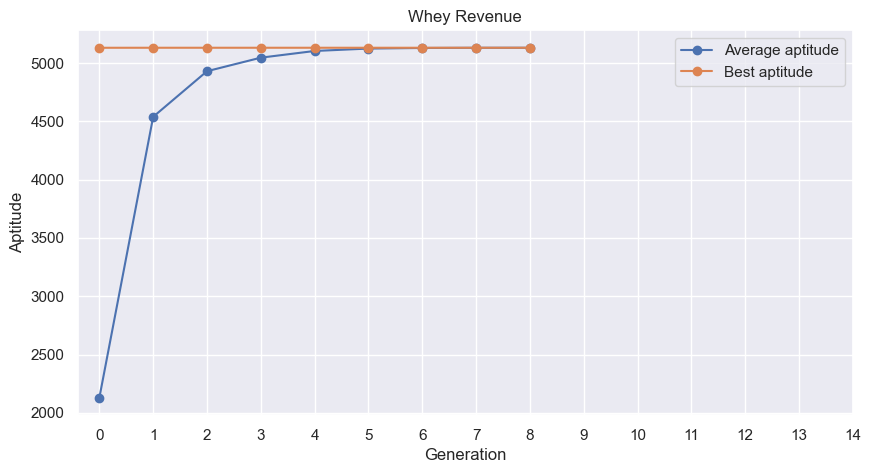

In [21]:
def genetic_competence(population: np.ndarray, childrens: np.ndarray):
    all_population = np.vstack([population, childrens])
    sorted_population, _, _, _ = evaluate_population(all_population, (0, 5), revenue_whey)
    return sorted_population[:population.shape[0]]


whey_population = init_binary_population(100, 2**4)
generations = 15
epsilon = 3000
last_avg_aptitude = float("inf")
max_stagnant_generations = 3
stagnant_generations = 0
delta = 30

avg_aptitudes_l = []
max_aptitudes_l = []
evolution_l = []

for _ in range(generations):
    whey_population, _, avg_aptitude, max_aptitude = evaluate_population(whey_population, (0, 5), revenue_whey)
    avg_aptitudes_l.append(avg_aptitude)
    max_aptitudes_l.append(max_aptitude)
    evolution_l.append(whey_population.copy())
    
    if abs(avg_aptitude - last_avg_aptitude) < delta:
        stagnant_generations += 1
        if stagnant_generations > max_stagnant_generations:
            break
    else:
        stagnant_generations = 0

    last_avg_aptitude = avg_aptitude
    parents = polygamous_random_selection(whey_population)
    childrens = two_point_crossover(whey_population, parents)
    childrens = inverse_mutation(childrens, 0.2)
    whey_population = genetic_competence(whey_population, childrens)

print(f"Best price: {decode_individue(whey_population[-1], (0, 5))}")
print(f"Best aptitude: {max_aptitudes_l[-1]}")
print(f"Avg aptitude: {avg_aptitudes_l[-1]}")

title = "Whey Revenue"
plot_aptitude(avg_aptitudes_l, max_aptitudes_l, generations, title)


$$P_{premium} = 2.0259$$
$$P_{tradicional} = 2.2284$$